In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SEED = 1987
data_dir = ''
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [3]:
# This part is optional for if you want to train only on most popular classes. 
# NUM_CLASSES = 16
# selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
# labels = labels[labels['breed'].isin(selected_breed_list)]

In [4]:
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
labels_pivot = labels_pivot.drop('id', axis=1)
y_train = labels_pivot.values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [5]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [6]:
INPUT_SIZE = 299
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:59, 171.35it/s]


Train Images shape: (10222, 299, 299, 3) size: 2,741,571,066


In [7]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

((8140, 299, 299, 3), (2082, 299, 299, 3), (8140, 120), (2082, 120))


In [8]:
del x_train

In [9]:
POOLING='none'
model_vgg = xception.Xception(weights='imagenet',include_top=True, input_shape = (INPUT_SIZE,INPUT_SIZE,3),pooling=POOLING)

In [10]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling='avg')

In [11]:
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=2)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=2)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

Xception train bottleneck features shape: (8140, 2048) size: 16,670,720
Xception valid bottleneck features shape: (2082, 2048) size: 4,263,936


In [14]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(120)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(120)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.35417187323362515
Validation Xception Accuracy 0.8861671469740634


In [15]:
intermediate_layer_model = Model(inputs=model_vgg.input,
                                  outputs=model_vgg.get_layer('block14_sepconv2_act').output)

In [16]:
train_vgg_bf = intermediate_layer_model.predict(Xtr, batch_size=32, verbose=2)

In [17]:
valid_vgg_bf = intermediate_layer_model.predict(Xv, batch_size=32, verbose=2)
print(train_vgg_bf.shape,valid_vgg_bf.shape)

(8140, 10, 10, 2048) (2082, 10, 10, 2048)


In [23]:
inputs = Input(shape=(2048,))
#x = Flatten()(inputs)
#x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(inputs)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(ytr.shape[1], activation='softmax',name='Last_softmax')(x) 
model = Model(inputs, outputs=predictions)

In [ ]:
#model.get_layer('fc1').trainable = False 

In [ ]:
#model.get_layer('fc1').trainable

In [24]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics = ["accuracy"])

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=2)
history = model.fit(x = train_x_bf, y = ytr[:,:], epochs = 100, batch_size = 8140,
          validation_data = [valid_x_bf,yv[:,:]],callbacks=[reduce_lr], verbose=1)

Train on 8140 samples, validate on 2082 samples
Epoch 1/100
8140/8140 [==============================] - 2s 278us/step - loss: 8.2102 - acc: 0.0095 - val_loss: 4.5023 - val_acc: 0.0346
Epoch 2/100
8140/8140 [==============================] - 0s 19us/step - loss: 7.7417 - acc: 0.0150 - val_loss: 3.9065 - val_acc: 0.2080
Epoch 3/100
8140/8140 [==============================] - 0s 20us/step - loss: 7.0990 - acc: 0.0213 - val_loss: 3.3084 - val_acc: 0.4424
Epoch 4/100
8140/8140 [==============================] - 0s 23us/step - loss: 6.4572 - acc: 0.0332 - val_loss: 2.7430 - val_acc: 0.6182
Epoch 5/100
8140/8140 [==============================] - 0s 22us/step - loss: 5.8774 - acc: 0.0534 - val_loss: 2.2352 - val_acc: 0.7099
Epoch 6/100
8140/8140 [==============================] - 0s 20us/step - loss: 5.3098 - acc: 0.0883 - val_loss: 1.8049 - val_acc: 0.7546
Epoch 7/100
8140/8140 [==============================] - 0s 22us/step - loss: 4.7964 - acc: 0.1127 - val_loss: 1.4598 - val_acc: 0.7800

Epoch 61/100
8140/8140 [==============================] - 0s 21us/step - loss: 0.6604 - acc: 0.8144 - val_loss: 0.3409 - val_acc: 0.8881
Epoch 62/100
8140/8140 [==============================] - 0s 20us/step - loss: 0.6409 - acc: 0.8127 - val_loss: 0.3407 - val_acc: 0.8886
Epoch 63/100
8140/8140 [==============================] - 0s 20us/step - loss: 0.6531 - acc: 0.8087 - val_loss: 0.3406 - val_acc: 0.8886
Epoch 64/100
8140/8140 [==============================] - 0s 20us/step - loss: 0.6493 - acc: 0.8057 - val_loss: 0.3404 - val_acc: 0.8890
Epoch 65/100
8140/8140 [==============================] - 0s 20us/step - loss: 0.6463 - acc: 0.8145 - val_loss: 0.3402 - val_acc: 0.8895
Epoch 66/100
8140/8140 [==============================] - 0s 22us/step - loss: 0.6291 - acc: 0.8120 - val_loss: 0.3401 - val_acc: 0.8890
Epoch 67/100
8140/8140 [==============================] - 0s 19us/step - loss: 0.6233 - acc: 0.8147 - val_loss: 0.3400 - val_acc: 0.8890
Epoch 68/100
8140/8140 [=================

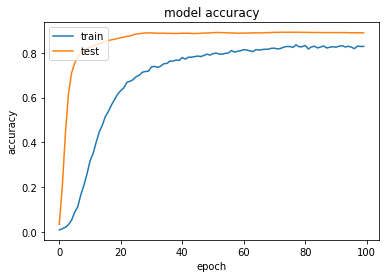

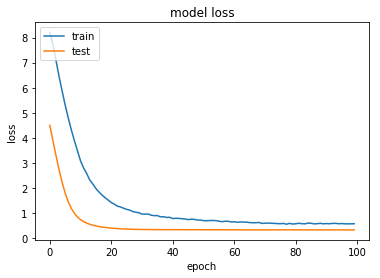

In [26]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('trained_weights_vgg16_stage1.h5')

In [ ]:
#model.load_weights('trained_weights_resenet50_stage1.h5')

In [ ]:
for i, layer in enumerate(model.layers):
   layer.trainable = True

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics = ["accuracy"])
model.fit(x = Xtr, y = ytr[:,1:], epochs = 20, batch_size = 4,validation_data = [Xv,yv[:,1:]],callbacks=[reduce_lr, early_stopping])

In [ ]:
model.save_weights('trained_weights_vgg16.h5')

Creating submission file

In [ ]:
INPUT_SIZE = 224
for i, img_id in tqdm(enumerate(sample_submission['id'])):
    img = read_img(img_id, 'test', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    y = model.predict(x)
    sample_submission.iloc[i,1:121] = np.asarray(y[0,0:120])

In [ ]:
#sample_submission.iloc[1,1:121] = np.asarray(y[0,0:120])

In [ ]:
#sample_submission.head()

In [ ]:
sample_submission.to_csv('submission4.csv',index=False)